In [1]:
from pomegranate import *
import numpy
import csv
import itertools
import sys
import os

In [2]:
os.getcwd()

'/home/philip/Learning/Computer_Science/CS50_Python/Projects/heredity/pomegranate'

In [3]:
#PROBS["mutation"]
mu = 0.01
data_index = 0

In [4]:

def load_data(filename):
    """
    Load gene and trait data from a file into a dictionary.
    File assumed to be a CSV containing fields name, mother, father, trait.
    mother, father must both be blank, or both be valid names in the CSV.
    trait should be 0 or 1 if trait is known, blank otherwise.
    """
    data = dict()
    with open(filename) as f:
        reader = csv.DictReader(f)
        for row in reader:
            name = row["name"]
            data[name] = {
                "name": name,
                "mother": row["mother"] or None,
                "father": row["father"] or None,
                "trait": (True if row["trait"] == "1" else
                          False if row["trait"] == "0" else None)
            }
    return data



people = load_data(f'../data/family{data_index}.csv')
people


{'Harry': {'name': 'Harry',
  'mother': 'Lily',
  'father': 'James',
  'trait': None},
 'James': {'name': 'James', 'mother': None, 'father': None, 'trait': True},
 'Lily': {'name': 'Lily', 'mother': None, 'father': None, 'trait': False}}

In [5]:

nodes = {
    person: {
        "gene": Node(
            DiscreteDistribution({
                "2": 0.01,
                "1": 0.03,
                "0": 0.96})
        , name=person)
    }
    for person in people
}


In [7]:
for person in people:
    if (people[person]['mother']!=None) & (people[person]['father']!=None):
        nodes[person]['gene'] =  Node(ConditionalProbabilityTable([
                ["2", "2", "2", (1-mu)*(1-mu)],
                ["2", "2", "1", 2*(1-mu)*mu],
                ["2", "2", "0", mu*mu],

                ["2", "1", "2", (1-mu)*0.5],
                ["2", "1", "1", ((1-mu)*0.5 + mu*0.5)],
                ["2", "1", "0", mu*0.5],

                ["2", "0", "2", (1-mu)*mu],
                ["2", "0", "1", 1-2*mu+2*mu**2],
                ["2", "0", "0", mu*(1-mu)],

                ["1", "2", "2", 0.5*(1-mu)],
                ["1", "2", "1", 0.5],
                ["1", "2", "0", 0.5*mu],

                ["1", "1", "2", 0.25],
                ["1", "1", "1", 0.5],
                ["1", "1", "0", 0.25],

                ["1", "0", "2", 0.5*mu],
                ["1", "0", "1", 0.5],
                ["1", "0", "0", 0.5*(1-mu)],

                ["0", "2", "2", mu*(1-mu)],
                ["0", "2", "1", mu*mu+(1-mu)*(1-mu)],
                ["0", "2", "0", (1-mu)*mu],

                ["0", "1", "2", mu*0.5],
                ["0", "1", "1", 0.5],
                ["0", "1", "0", (1-mu)*0.5],

                ["0", "0", "2", mu*mu],
                ["0", "0", "1", 2*mu*(1-mu)],
                ["0", "0", "0", (1-mu)*(1-mu)]],
            [nodes[people[person]['mother']]['gene'].distribution, nodes[people[person]['father']]['gene'].distribution]),
        name=person)


In [8]:
for person in people:
    #Track trait node is conditional on person
    print(person)
    nodes[person]['trait'] = Node(ConditionalProbabilityTable([
        ["2", 'yes', 0.65],
        ["2", 'no', 0.35],
        ["1", 'yes', 0.56],
        ["1", 'no', 0.44],
        ["0", 'yes', 0.01],
        ["0", 'no', 0.99]
    ], [nodes[person]['gene'].distribution]), name=person+"_trait")


Harry
James
Lily


In [9]:
# create the general Bayesian network
model = BayesianNetwork()


# add node into this network
for person in people:
    model.add_states(nodes[person]['gene'])
    model.add_states(nodes[person]['trait'])


In [10]:
# Add edges connecting nodes
for person in people:
    model.add_edge(nodes[person]['gene'], nodes[person]['trait'])
        
    if people[person]['mother']:
        model.add_edge(nodes[people[person]['mother']]['gene'], nodes[person]['gene'])
        
    if people[person]['father']:
        model.add_edge(nodes[people[person]['father']]['gene'], nodes[person]['gene'])


In [11]:
# Finalize model
model.bake()

In [12]:
for person in people:
    print(f"-----------{person}-----------:")
    for field in nodes[person]:
        print(f"  {field.capitalize()}:")
        print(nodes[person][field].distribution)


-----------Harry-----------:
  Gene:
2	2	0	0.00010000000000000009
2	2	1	0.019799999999999998
2	2	2	0.9801
2	1	0	0.005000000000000002
2	1	1	0.5
2	1	2	0.495
2	0	0	0.009899999999999999
2	0	1	0.9802
2	0	2	0.009899999999999999
1	2	0	0.005000000000000002
1	2	1	0.5
1	2	2	0.495
1	1	0	0.25
1	1	1	0.5
1	1	2	0.25
1	0	0	0.495
1	0	1	0.5
1	0	2	0.005000000000000002
0	2	0	0.009899999999999999
0	2	1	0.9802
0	2	2	0.009899999999999999
0	1	0	0.495
0	1	1	0.5
0	1	2	0.005000000000000002
0	0	0	0.9801
0	0	1	0.019799999999999998
0	0	2	0.00010000000000000009
  Trait:
0	yes	0.010000000000000004
0	no	0.99
1	yes	0.56
1	no	0.44
2	yes	0.65
2	no	0.3499999999999999
-----------James-----------:
  Gene:
{
    "class" :"Distribution",
    "dtype" :"str",
    "name" :"DiscreteDistribution",
    "parameters" :[
        {
            "2" :0.01,
            "1" :0.03,
            "0" :0.96
        }
    ],
    "frozen" :false
}
  Trait:
2	yes	0.65
2	no	0.3499999999999999
1	yes	0.56
1	no	0.44
0	yes	0.010000000000000004
0	no	0.9

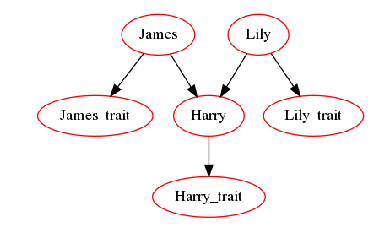

In [13]:
model.plot()

In [14]:
# Incorporate the trait data into the model
input_dict = {}
for person in people:
    if people[person]['trait']==0:
        input_dict[person+'_trait'] = 'no'
    elif people[person]['trait']==1:
        input_dict[person+'_trait'] = 'yes'

In [15]:
#Calculate predictions
predictions = model.predict_proba(input_dict)


# Print predictions for each node
for node, prediction in zip(model.states, predictions):
    if isinstance(prediction, str):
        print(f"{node.name}: {prediction}")
    else:
        print(f"{node.name}")
        for value, probability in prediction.parameters[0].items():
            print(f"    {value}: {probability:.4f}")

Harry
    0: 0.5351
    1: 0.4557
    2: 0.0092
Harry_trait
    yes: 0.2665
    no: 0.7335
James
    2: 0.1976
    1: 0.5106
    0: 0.2918
James_trait: yes
Lily
    2: 0.0036
    1: 0.0136
    0: 0.9827
Lily_trait: no
